# **Convolutional Neural Network - Computer Vision (Classification)**

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
</head>
<body>
    </header>
    <section>
        <p><strong>Student:</strong> Ian H. Ryan</p>
        <p><strong>Instructor:</strong> Dr. Soltys</p>
        <p><strong>School:</strong> California State University Channel Islands</p>
        <p><strong>Term:</strong> Fall 2024</p>
        <p><strong>Project:</strong> COMP 499 - Capstone</p>
    </section>
</body>
</html>

## **Description:**

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>CNN Project Overview</title>
</head>
<body>
    <p>
        In this notebook, we will create a <strong>Convolutional Neural Network (CNN)</strong> for Computer Vision. We will <em>NOT</em> be using pre-trained models. Specifically, we will build a CNN for Classification.
    </p>
    <p>
        Before that point, we will be combining two varying datasets into a combined dataset that has an imbalance and then saving it. The reason for adding the second dataset to the first is that I did not want to build a single-layer perceptron (CNN with one layer/simplest neural network) with just humans.
    </p>
    <p>
        The first dataset just has <strong>person</strong> as one classifier and consists of 902 <code>640x640</code> images of humans. The second dataset consists of multiple animals that I refined down to match at 902 varying-sized images but of animals with 17 different classifiers of varying animals. Once this is done and the newly saved combined dataset is saved, it will be normalized before starting pre-processing.
    </p>
    <p>
        After that, we will begin the pre-processing for the dataset. Then...
    </p>
</body>
</html>


# **Index**

## **Table of Contents**
- [Libraries & Imports](#libim)
  - [Libraries](#libraries)
  - [Imports](#imports)
  - [CUDA GPU Availability](#checkgpucuda)
- [Download & Load Datasets](#download-datasets)
  - [First Dataset Resource](#first-dataset-resource)
  - [Second Dataset Resource](#second-dataset-resource)
  - [Functions](#functions)
  - [Path Datasets](#path-datasets)
    - [First Dataset](#first-dataset)
    - [Second Dataset](#second-dataset)
- [Pre-Processing The Datasets](#preprocessing)
  - [Combine Datasets](#combine-datasets)
  - [Save Combo Set](#save-combo-set)
  - [DEBUG - Redistribute Images Dynamically](#debug-redistribute)
  - [Comboset Pathing](#comboset-pathing)
    - [Normalize File Extensions](#normalize-file-extensions)
    - [Combo Transforms Train Valid Test](#combo-transforms)
    - [Extensive Pathing Checking](#extensive-pathing)
  - [Transforms & Loaders](#transforms-loaders)
- [Classification Or Object Detection Model?](#model-task)
  - [Classification Task](#classification-task)
  - [Regression Task](#regression-task)
- [CNN Model](#cnn-model)
  - [Define Class Weights](#define-class-weights)
  - [Define CNN Model Architecture](#define-cnn-model)
  - [Weights & Biases](#weights-biases)
  - [Hyperparameters](#hyperparameters)
  - [Class Confirmation in Training Data](#class-confirmation)
  - [Profile Memory Usage](#profile-memory)
  - [Comboset Training Prep](#training-prep)
  - [Weight Initialization](#weight-initialization)
- [Training CNN Model](#training-model)
  - [Test Accuracy of Convolutional Neural Network](#test-accuracy)
  - [Visualizations](#visualizations)
    - [Summary - Everything](#summary)
    - [Model Performance Function](#model-performance)
    - [Training & Validation Loss Plots](#training-validation-loss)
    - [Confusion Matrices](#confusion-matrices)
    - [Feature Maps](#feature-maps)
    - [Kernel Visualizations](#kernel-visualizations)
    - [Gradient Visualizations](#gradient-visualizations)
    - [CAM / Grad-CAM](#cam-grad-cam)
    - [Training/Validation Curves](#training-validation-curves)
    - [Explainability Tools](#explainability-tools)
- [Recommended Resources](#recres)
- [Acknowledgements](#acknow)
- [Literature Cited](#litcit)

# **Libraries & Imports** <a id="libim"></a>

## Libraries<a id="libraries"></a>

In [3]:
%%capture


# instal the libraries
!pip install -U -q -r requirements.txt

Restart Kernel by running following cell.

In [4]:
from IPython.display import HTML, display
def restart_kernel_and_run_all_cells():
    display(HTML(
        '''
            <script>
                code_show = false;
                var cell_idx = Jupyter.notebook.get_cell_elements().index(cell_element);
                cell_idx++;
                function restart(){
                    IPython.notebook.kernel.restart();
                    IPython.notebook.execute_cells([cell_idx])
                }
                restart()
            </script>
        '''
    ))
#print("Before you continue, wait until the kernel is ready again.")
restart_kernel_and_run_all_cells()

## Imports <a id="imports"></a>

In [5]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from torch import nn
import torchvision
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torch.utils.data import WeightedRandomSampler
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import SGD
from torch.cuda.amp import GradScaler, autocast
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F
import random
import numpy as np
from torchviz import make_dot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from torchsummary import summary
from sklearn.pipeline import Pipeline
import shutil
from PIL import Image
from collections import Counter

## Check GPU Availability for CUDA? <a id="checkgpucuda"></a>

In [6]:
print("CUDA available:", torch.cuda.is_available())
print("# of GPUs Available:", torch.cuda.device_count())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

CUDA available: True
# of GPUs Available: 1


'cuda'

# Download & Load Datasets <a id="download-datasets"></a>
Datasets for CNN Model Training for human detection that has the following classes:
- person (from INRIA-pdd)    902 human images (train - 70%, test - 10%, val - 20%)
- animals (17 total classes) [from animal]     902 non-human images (train - 70%, test - 10%, val - 20%)

### First Dataset Resource <a id="first-dataset-resource"></a>

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
</head>
<body>

<p>
    Access the dataset here: 
    <a href="https://universe.roboflow.com/pascal-to-yolo-8yygq/inria-person-detection-dataset" target="_blank">
        INRIA Person Detection Dataset
    </a>
</p>

<p>
    <strong>Credit:</strong> Dataset created by <em>[Pascal to Yolo]</em> and hosted on 
    <a href="https://universe.roboflow.com/" target="_blank">Roboflow Universe</a>.
</p>

</body>
</html>

### Second Dataset Resource <a id="second-dataset-resource"></a>

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <style>
        body {
            font-family: Arial, sans-serif;
            line-height: 1.6;
        }
        h2 {
            color: #333;
        }
        a {
            color: #0066cc;
            text-decoration: none;
        }
        a:hover {
            text-decoration: underline;
        }
    </style>
</head>
<body>


<p>
    Access the dataset here: 
    <a href="https://www.kaggle.com/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/data" target="_blank">
        Animal Image Dataset (90 Different Animals)
    </a>
</p>

<p>
    <strong>Credit:</strong> Dataset created by <em>Sourav Banerjee</em> and hosted on 
    <a href="https://www.kaggle.com/" target="_blank">Kaggle</a>.
</p>

</body>
</html>

### Functions <a id="functions"></a>

#### Recursive remove .ipynb_checkpoints folders at directed folder.
Yes, Unfortunately this notebook problem keeps appearing so thus recursive. call function for each dataset upload path. this will fix a bug in AWS SageMaker that keeps recognizing .ipynb_checkpoints in folders it is not in. Call when needed for .ipynb_checkpoints error

In [7]:
def clean_checkpoints(base_path):
    """
    Recursively remove all .ipynb_checkpoints folders in a directory.
    """
    for root, dirs, _ in os.walk(base_path):
        for folder in dirs:
            if folder == '.ipynb_checkpoints':
                checkpoint_path = os.path.join(root, folder)
                shutil.rmtree(checkpoint_path)
                print(f"Removed: {checkpoint_path}")

#### Normalize Filenames 
If the issue is due to case sensitivity or special characters, normalize the filenames with this function:

In [8]:
def normalize_filenames(directory):
    """
    Normalize filenames in the given directory and its subdirectories.
    Ensures all filenames are in lowercase and replace spaces with underscores.
    Args:
        directory (str): Path to the directory to normalize filenames.
    """
    for root, _, files in os.walk(directory):
        for file in files:
            old_path = os.path.join(root, file)
            # Normalize filename
            normalized_name = file.lower().replace(" ", "_")
            new_path = os.path.join(root, normalized_name)
            # Rename file if necessary
            if old_path != new_path:
                os.rename(old_path, new_path)
                print(f"Renamed: {old_path} -> {new_path}")

## Path Datasets <a id="path-datasets"></a>

#### _First Dataset_ <a id="first-dataset"></a>

In [9]:
in_path = 'data/INRIA-pdd'
train_path = os.path.join(in_path, 'train')
val_path = os.path.join(in_path, 'valid')
test_path = os.path.join(in_path, 'test')
# Clean checkpoints in the dataset directory
clean_checkpoints(in_path)

### .ipynb_checkpoints Debugging

In [10]:
# CHECK IF .ipynb_checkpoints EXISTS
valid_path = os.path.join(in_path, 'valid')

# Check if .ipynb_checkpoints exists
checkpoint_path = os.path.join(valid_path, '.ipynb_checkpoints')
if os.path.exists(checkpoint_path):
    print(f".ipynb_checkpoints exists at: {checkpoint_path}")
else:
    print(".ipynb_checkpoints does not exist.")

.ipynb_checkpoints does not exist.


In [11]:
# This kills the checkpoint error. Run if getting it.
# Path dir path
valid_path = os.path.join(in_path, 'valid')

# decimate ipynb_checkpoints folder
checkpoint_path = os.path.join(valid_path, '.ipynb_checkpoints')
if os.path.exists(checkpoint_path):
    shutil.rmtree(checkpoint_path)
    print(f"decimated: {checkpoint_path}")
else:
    print(f".ipynb_checkpoints folder found at {checkpoint_path}")

.ipynb_checkpoints folder found at data/INRIA-pdd/valid/.ipynb_checkpoints


In [12]:
valid_path = 'data/INRIA-pdd/valid'
print(f"Contents of valid directory after cleanup: {os.listdir(valid_path)}")

Contents of valid directory after cleanup: ['person']


##### Inspect test path and confirm it has class folders and these folders have valid files.

In [13]:
# Verify test_path exists
print(f"Test path exists: {os.path.exists(test_path)}")
print(f"Test path: {test_path}")

Test path exists: True
Test path: data/INRIA-pdd/test


In [14]:
#Valid path?

valid_path = os.path.join(in_path, 'valid')
person_path = os.path.join(valid_path, 'person')

# Check if the directory exists
print(f"Does 'person' class directory exist? {os.path.exists(person_path)}")

# List files in the 'person' directory
if os.path.exists(person_path):
    print(f"Files in 'person' directory: {os.listdir(person_path)}")
else:
    print("'person' class directory not found.")


Does 'person' class directory exist? True
Files in 'person' directory: ['person_and_bike_039_jpg.rf.095d9470ebf980db5ca6887a7069b6b8.jpg', 'crop001688_jpg.rf.4585afeacb62b7db23579495cd56e52b.jpg', 'crop001649_jpg.rf.bb709462351976d46578cd7cd66b4490.jpg', 'person_040_jpg.rf.275f906a9c5718bedad236bc3125046e.jpg', 'person_and_bike_126_jpg.rf.4c936ba0fd2d678507654f7f554c0a42.jpg', 'person_and_bike_134_jpg.rf.baf619016be1d7376a5c53749d2d07c6.jpg', 'person_255_jpg.rf.88856801c26568810c6f6c61703a2862.jpg', 'person_138_jpg.rf.92a7bffe6de6019a7276dbd1633630b0.jpg', 'person_and_bike_085_jpg.rf.618fd759e87b635973e34aad516ccaae.jpg', 'crop001250_jpg.rf.3cf356f6c7428fb9e0646b2375abf269.jpg', 'crop_000027_jpg.rf.17584aceea954667eed0915c408e1d15.jpg', 'person_247_jpg.rf.05bdb5ec66a45ff3a16247367491e84b.jpg', 'crop001715_jpg.rf.f3885290db4f316dd81b411539861f14.jpg', 'crop001013_jpg.rf.89f209885c7906c5e695037d5511646f.jpg', 'person_and_bike_165_jpg.rf.24303b6ee9103b5351339426780cd644.jpg', 'person_and_

##### OPTIONAL: Check that dataset loaded properly by printing a few images.

In [15]:
# List classes and their files in test_path
if os.path.exists(test_path):
    classes = os.listdir(test_path)
    print(f"Classes in test_path: {classes}")

    for class_name in classes:
        class_dir = os.path.join(test_path, class_name)
        if os.path.isdir(class_dir):
            print(f"Files in class '{class_name}': {os.listdir(class_dir)}")
        else:
            print(f"{class_name} is not a directory!")

Classes in test_path: ['person']
Files in class 'person': ['crop_000023_jpg.rf.2526972717a30fb6d6dc02b9fc151eb9.jpg', 'crop001200_jpg.rf.8c4461c33779cb3387d5bc77d2ccfe67.jpg', 'person_236_jpg.rf.89666b65da6c8f7ddb111185776011f4.jpg', 'crop001613_jpg.rf.3647c6459459bac1b2624413c5139b14.jpg', 'crop001712_jpg.rf.5035be3fa00b6ba52e43b8ba0e2fb762.jpg', 'person_and_bike_023_jpg.rf.cb93e050029ec4eac0afde9d3c793240.jpg', 'crop001106_jpg.rf.ecb1e67f01504f8b21faa70866edafb9.jpg', 'person_257_jpg.rf.dccc5d3f09a7740c9d8af54eb3759660.jpg', 'person_and_bike_053_jpg.rf.96a0249b2056df6b1752d7f7ed8ca5d8.jpg', 'person_and_bike_011_jpg.rf.beaf3979cd73bd0accc4a5b64787fdd7.jpg', 'crop001022_jpg.rf.21e7055a8621ab099b54abb19db87a67.jpg', 'crop001691_jpg.rf.beb96854c31ebc7f0a01611fd56c8431.jpg', 'person_137_jpg.rf.ba69078499aae07e3489933b82015003.jpg', 'person_and_bike_074_jpg.rf.f28f972a4992db8cf2d6a5495005ebba.jpg', 'crop001092_jpg.rf.b75a126fc8cf5cc19c234a4aae22d486.jpg', 'crop001510_jpg.rf.5739f77c734b869

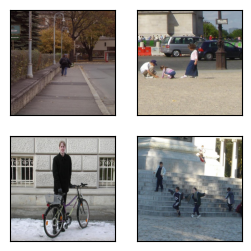

In [16]:
# not required but useful to see the imported data quickly and randomly.
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.permute(1,2,0).numpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

# Peek at some of the dataset images!

test_dataset = ImageFolder(test_path, transform=transforms.ToTensor())
test_sample = DataLoader(test_dataset, batch_size=2*8, shuffle=True)

# You can run this cell over and over seeing different images.
for data, label in test_sample:
    show_images(data, 2, 2);
    break

#### _Second Dataset_ <a id="first-dataset"></a>

In [17]:
an_path = 'data/animal'
train_path = os.path.join(an_path, 'train')
val_path = os.path.join(an_path, 'valid')
test_path = os.path.join(an_path, 'test')

clean_checkpoints(an_path)

##### ***IF CLASSES != correct amount make sure all the files are correct***

In [18]:
# Verify the test_path for 'animal'
print(f"Test path exists: {os.path.exists(test_path)}")
print(f"Classes in test path: {os.listdir(test_path) if os.path.exists(test_path) else 'Not Found'}")

# Verify class folders and their contents
if os.path.exists(test_path):
    for class_name in os.listdir(test_path):
        class_dir = os.path.join(test_path, class_name)
        if os.path.isdir(class_dir):
            print(f"Files in class '{class_name}': {os.listdir(class_dir)}")
        else:
            print(f"'{class_name}' is not a directory!")

Test path exists: True
Classes in test path: ['starfish', 'gorilla', 'penguin', 'zebra', 'whale', 'orangutan', 'possum', 'cat', 'badger', 'wombat', 'elephant', 'chimpanzee', 'porcupine', 'rhinoceros', 'cow', 'sheep', 'coyote']
Files in class 'starfish': ['4ed59ad8bb.jpg', '4ca966d1ac.jpg', '006e7b1af6.jpg', '4c25b3331f.jpg', '4ed33f345c.jpg', '4e97c34e1d.jpg']
Files in class 'gorilla': ['6c698898f6.jpg', '7d80858fbb.jpg', '7bac92b151.jpg', '6c571eb6cc.jpg', '7c8e5ebd9a.jpg']
Files in class 'penguin': ['4b769c6694.jpg', '3a341e64eb.jpg', '2defe423b8.jpg', '3cc3579c05.jpg', '2e3234801c.jpg']
Files in class 'zebra': ['7f892f3977.jpg', '7f3f1ddc56.jpg', '7ae826e4ac.jpg', '6eebb7baff.jpg', '7d35713fda.jpg', '7b7d8759f1.jpg']
Files in class 'whale': ['6ad9e54d17.jpg', '7a30c295f9.jpg', '7c158a9839.jpg', '6d52fa4f3a.jpg', '6a6de3c60c.jpg', '6e369955c0.jpg']
Files in class 'orangutan': ['5ec0c80431.jpg', '6e0d356e20.jpg', '6af57cbe60.jpg', '6e09844651.jpg', '6cb56c49ac.jpg']
Files in class 'po

## Pre-Processing The Datasets <a id="preprocessing"></a>
- resize images to all same pixel size if needed.
- Tensor conversion to float.
- Normalize tensor.

Transformer needs to be applied to ALL images in datasets.

In [19]:
calculated_mean = [0.4713, 0.4595, 0.4212]
calculated_std = [0.2065, 0.2032, 0.2050]

# transformer for INRA-pdd
in_transformation = transforms.Compose([
    transforms.Resize((320, 320)),  # Change resizing to 320x320
    transforms.ToTensor(),
    transforms.Normalize(mean=calculated_mean, std=calculated_std)
])

# transformer for animal
an_transformation = transforms.Compose([
    transforms.Resize((320, 320)),  # Change resizing to 320x320
    transforms.ToTensor(),
    transforms.Normalize(mean=calculated_mean, std=calculated_std)
])

# Data augmentation for training dataset
train_transformation = transforms.Compose([
    transforms.Resize((320, 320)),  # Change resizing to 320x320
    transforms.RandomHorizontalFlip(),              # Randomly flip images horizontally
    transforms.RandomRotation(5),                  # Randomly rotate images by 10 degrees
    transforms.ColorJitter(brightness=0.1,          # Random brightness adjustment
                           contrast=0.1),           # Random contrast adjustment
    transforms.ToTensor(),                          # Convert images to tensors
    transforms.Normalize(mean=calculated_mean, std=calculated_std)
])

# Basic transformation for validation and test datasets
val_test_transformation = transforms.Compose([
    transforms.Resize((320, 320)),  # Change resizing to 320x320
    transforms.ToTensor(),
    transforms.Normalize(mean=calculated_mean, std=calculated_std)
])

##### Verify the class from the folder are the only objects showing up in the output.

In [20]:
print(os.path.join(in_path, 'valid'))
print(os.listdir(os.path.join(in_path, 'valid')))

data/INRIA-pdd/valid
['person']


Shows number of classes in data followed by the number of samples in the  validate section.

In [21]:
# Reload the valid dataset
in_val = ImageFolder(os.path.join(in_path, 'valid'), transform=in_transformation)

print(f"Classes in valid dataset: {in_val.classes}")
print(f"Number of samples in valid dataset: {len(in_val)}")

Classes in valid dataset: ['person']
Number of samples in valid dataset: 180


#### Combine Datasets <a id="combine-datasets"></a>

In [22]:
# Goal of merging the two datasets into one.
in_train = ImageFolder(os.path.join(in_path, 'train'), transform=in_transformation)
an_train = ImageFolder(os.path.join(an_path, 'train'), transform=an_transformation)
train_dataset = ConcatDataset([in_train, an_train])

# Validation datasets
in_val = ImageFolder(os.path.join(in_path, 'valid'), transform=in_transformation)
an_val = ImageFolder(os.path.join(an_path, 'valid'), transform=an_transformation)
val_dataset = ConcatDataset([in_val, an_val])

# Test datasets
in_test = ImageFolder(os.path.join(in_path, 'test'), transform=in_transformation)
an_test = ImageFolder(os.path.join(an_path, 'test'), transform=an_transformation)
test_dataset = ConcatDataset([in_test, an_test])

# Extract classes from individual datasets
in_classes = in_train.classes
an_classes = an_train.classes

# Combo class lists
combined_classes = in_classes + an_classes
print(f"Combo Classes: {combined_classes}")
print(f"# of Combo Classes: {len(combined_classes)}")

# Adjust labels for animal dataset
offset = len(in_train.classes)  # Num classes in INRIA-pdd
for i in range(len(an_train.samples)):
    path, label = an_train.samples[i]
    an_train.samples[i] = (path, label + offset)

# Set the number of output classes dynamically
# out_classes = len(combined_classes)
# print(f"Number of Output Classes: {out_classes}")

# Verify adjustments
print(f"Adjusted labels in animal dataset: {set(label for _, label in an_train.samples)}")

in_test = ImageFolder(os.path.join(in_path, 'test'), transform=in_transformation)
an_test = ImageFolder(os.path.join(an_path, 'test'), transform=an_transformation)

Combo Classes: ['person', 'badger', 'cat', 'chimpanzee', 'cow', 'coyote', 'elephant', 'gorilla', 'orangutan', 'penguin', 'porcupine', 'possum', 'rhinoceros', 'sheep', 'starfish', 'whale', 'wombat', 'zebra']
# of Combo Classes: 18
Adjusted labels in animal dataset: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}


In [23]:
train_dataset = ConcatDataset([in_train, an_train])
val_dataset = ConcatDataset([in_val, an_val])
test_dataset = ConcatDataset([in_test, an_test])

# Check dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 1264
Validation dataset size: 360
Test dataset size: 180


In [24]:
out_classes = 18

## Save Combo Set <a id="save-combo-set"></a>

In [25]:
def save_combined_dataset(train_dataset, val_dataset, test_dataset, combined_classes, save_path):
    """
    Save combined train, validation, and test datasets into a unified folder structure.
    Args:
        train_dataset: Combined training dataset
        val_dataset: Combined validation dataset
        test_dataset: Combined testing dataset
        combined_classes: List of class names
        save_path: Path to save the combined dataset
    """
    # Map the datasets to splits
    splits = {'train': train_dataset, 'valid': val_dataset, 'test': test_dataset}

    # Create the base save directory
    os.makedirs(save_path, exist_ok=True)

    for split_name, dataset in splits.items():
        split_path = os.path.join(save_path, split_name)
        os.makedirs(split_path, exist_ok=True)

        # Create folders for each class if they don't already exist
        for class_name in combined_classes:
            class_folder = os.path.join(split_path, class_name)
            os.makedirs(class_folder, exist_ok=True)

        # Iterate over each sample in the dataset
        for sub_dataset in dataset.datasets:  # Loop through datasets in ConcatDataset
            for image_path, label in sub_dataset.samples:  # Iterate through samples
                # Get the class name based on the label
                class_name = combined_classes[label]
                class_folder = os.path.join(split_path, class_name)

                # Destination path for the image
                dest_path = os.path.join(class_folder, os.path.basename(image_path))

                # Copy the image if it doesn't already exist
                if not os.path.exists(dest_path):
                    shutil.copy(image_path, dest_path)

    print(f"Combined dataset saved at: {save_path}")

# Save combined datasets
save_path = 'data/comboset'
save_combined_dataset(train_dataset, val_dataset, test_dataset, combined_classes, save_path)

Combined dataset saved at: data/comboset


## Redistribute Images Dynamically <a id="debug-redistribute"></a>

In [26]:
def redistribute_images(train_path, valid_path, test_path, combined_classes, valid_ratio=0.2, test_ratio=0.1):
    for class_name in combined_classes:
        train_class_path = os.path.join(train_path, class_name)
        valid_class_path = os.path.join(valid_path, class_name)
        test_class_path = os.path.join(test_path, class_name)

        # Ensure validation and test folders exist
        os.makedirs(valid_class_path, exist_ok=True)
        os.makedirs(test_class_path, exist_ok=True)

        train_images = os.listdir(train_class_path)
        valid_images = os.listdir(valid_class_path)
        test_images = os.listdir(test_class_path)

        total_images = len(train_images) + len(valid_images) + len(test_images)

        expected_valid_count = int(total_images * valid_ratio)
        expected_test_count = int(total_images * test_ratio)

        if len(valid_images) != expected_valid_count or len(test_images) != expected_test_count:
            print(f"Reallocating images for class: {class_name}")

            all_images = train_images + valid_images + test_images
            random.shuffle(all_images)

            new_valid_images = all_images[:expected_valid_count]
            new_test_images = all_images[expected_valid_count:expected_valid_count + expected_test_count]
            new_train_images = all_images[expected_valid_count + expected_test_count:]

            def safe_move(image_list, src_paths, dest_path):
                for src_path in src_paths:
                    for image in image_list:
                        src_image = os.path.join(src_path, image)
                        dest_image = os.path.join(dest_path, image)
                        
                        # Ensure source file exists before copying
                        if os.path.exists(src_image):
                            if not os.path.exists(dest_image):
                                shutil.copy(src_image, dest_image)
                            else:
                                print(f"File already exists: {dest_image}")
                        else:
                            print(f"File not found: {src_image}")

            # Copy images to respective folders
            src_paths = [train_class_path, valid_class_path, test_class_path]
            safe_move(new_valid_images, src_paths, valid_class_path)
            safe_move(new_test_images, src_paths, test_class_path)

            print(f"Class {class_name} redistributed: {len(new_train_images)} train, {len(new_valid_images)} valid, {len(new_test_images)} test.")

In [27]:
print(f"Combo Classes", combined_classes)

Combo Classes ['person', 'badger', 'cat', 'chimpanzee', 'cow', 'coyote', 'elephant', 'gorilla', 'orangutan', 'penguin', 'porcupine', 'possum', 'rhinoceros', 'sheep', 'starfish', 'whale', 'wombat', 'zebra']


## Comboset Pathing <a id="comboset-pathing"></a>

In [28]:
combo_path = 'data/comboset'
train_path = os.path.join(combo_path, 'train')
valid_path = os.path.join(combo_path, 'valid')
test_path = os.path.join(combo_path, 'test')

In [29]:
# Clean checkpoints in the dataset directory
clean_checkpoints(combo_path)

In [30]:
# Call the redistribute_images function with the corrected paths
redistribute_images(train_path, valid_path, test_path, combined_classes)

Reallocating images for class: person
File not found: data/comboset/train/person/crop001691_jpg.rf.beb96854c31ebc7f0a01611fd56c8431.jpg
File not found: data/comboset/train/person/crop001246_jpg.rf.cf2642284549dfb564ad05a4c71ffdd1.jpg
File not found: data/comboset/train/person/person_265_jpg.rf.c60ce390f383afbcb857a6d9da6ecec3.jpg
File not found: data/comboset/train/person/crop001113_jpg.rf.4730ddfd2ccab5678beea3cfa59c7f5b.jpg
File not found: data/comboset/train/person/crop001556_jpg.rf.e7a2c09df55221f438f148ed1da52cfc.jpg
File not found: data/comboset/train/person/person_091_jpg.rf.fc6ccf587867449d39a61292fc5e858f.jpg
File not found: data/comboset/train/person/crop001592_jpg.rf.c5d8abcc3bcbf7c83a7296f08e8bffb9.jpg
File not found: data/comboset/train/person/crop_000023_jpg.rf.2526972717a30fb6d6dc02b9fc151eb9.jpg
File not found: data/comboset/train/person/crop001145_jpg.rf.449a3b38d213e16fae50dfcb8f2f02ce.jpg
File not found: data/comboset/train/person/crop001577_jpg.rf.4d2460ba28c34f95ff

### Normalize File Extensions <a id="normalize-file-extensions"></a>

In [31]:
# TESTING THIS ONE. MIGHT NEED TO USE THIS OR THE OG ONE ABOVE TRYING RN
def normalize_file_extensions(folder):
    for root, _, files in os.walk(folder):
        for file in files:
            if file.endswith(('.JPG', '.JPEG', '.TIF', '.TIFF')):
                os.rename(
                    os.path.join(root, file),
                    os.path.join(root, file.lower())
                )

# Normalize valid path
normalize_file_extensions(combo_path)
normalize_file_extensions(valid_path)
normalize_file_extensions(train_path)

In [32]:
def get_combined_classes(directory):
    """
    Generate a list of class names based on folder names in the directory.
    Args:
        directory (str): Path to the dataset directory (e.g., train, valid, or test folder).
    Returns:
        list: Sorted list of class names.
    """
    if os.path.exists(directory):
        return sorted(next(os.walk(directory))[1])  # Get folder names in the directory
    else:
        raise FileNotFoundError(f"Directory {directory} does not exist.")

combined_classes = get_combined_classes(train_path)  # Assuming train_path contains the class folders
print(combined_classes)

['badger', 'cat', 'chimpanzee', 'cow', 'coyote', 'elephant', 'gorilla', 'orangutan', 'penguin', 'person', 'porcupine', 'possum', 'rhinoceros', 'sheep', 'starfish', 'whale', 'wombat', 'zebra']


### Combo Transforms <a id="combo-transforms"></a>

In [33]:
# pathing for comboset followed by corrupt checker
combo_path = "data/comboset"
train_path = os.path.join(combo_path, 'train')
valid_path = os.path.join(combo_path, 'valid')
test_path = os.path.join(combo_path, 'test')

# Call the redistribute_images function with the corrected paths
redistribute_images(train_path, valid_path, test_path, combined_classes)

Reallocating images for class: cat
File not found: data/comboset/train/cat/5d934fa43a.jpg
File not found: data/comboset/train/cat/2d6277e3c3.jpg
File not found: data/comboset/train/cat/08adb1cc98.jpg
File not found: data/comboset/train/cat/6cc604e915.jpg
File already exists: data/comboset/valid/cat/9293137b5d.jpg
File not found: data/comboset/train/cat/7e1abb3aa9.jpg
File not found: data/comboset/train/cat/4ebfe2df8e.jpg
File already exists: data/comboset/valid/cat/5d934fa43a.jpg
File already exists: data/comboset/valid/cat/087d293433.jpg
File already exists: data/comboset/valid/cat/2d6277e3c3.jpg
File already exists: data/comboset/valid/cat/354bb2acdf.jpg
File not found: data/comboset/valid/cat/08adb1cc98.jpg
File not found: data/comboset/valid/cat/6cc604e915.jpg
File already exists: data/comboset/valid/cat/9293137b5d.jpg
File not found: data/comboset/valid/cat/7e1abb3aa9.jpg
File already exists: data/comboset/valid/cat/66548aefad.jpg
File already exists: data/comboset/valid/cat/4ebfe

Debug the Dataset
Verify the dataset to ensure all images are valid and consistent.

Check for Corrupted Images
Use the following script to identify and optionally remove corrupted images:

In [34]:
def verify_images(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(root, file)
            try:
                img = Image.open(filepath)
                img.verify()  # Verify image integrity
            except Exception as e:
                print(f"Corrupted file: {filepath}, {e}")
                os.remove(filepath)  # Remove corrupted files (optional)

# Verify training and validation datasets
# verify_images('data/comboset/train')
# verify_images('data/comboset/valid')
verify_images(train_path)
verify_images(valid_path)
verify_images(test_path)

In [35]:
# Calculate mean and std training dataset
def calculate_mean_std(loader):
    mean = 0.
    std = 0.
    total_images = 0

    for data, _ in loader:
        batch_samples = data.size(0)  # Batch size (number of images in batch)
        total_images += batch_samples
        data = data.view(batch_samples, data.size(1), -1)  # Flatten HxW
        mean += data.mean(2).sum(0)  # Sum means across all pixels
        std += data.std(2).sum(0)  # Sum stds across all pixels

    mean /= total_images
    std /= total_images
    return mean, std

In [36]:
clean_checkpoints(combo_path)
# Normalize file extensions in class folder
normalize_file_extensions('data/comboset')

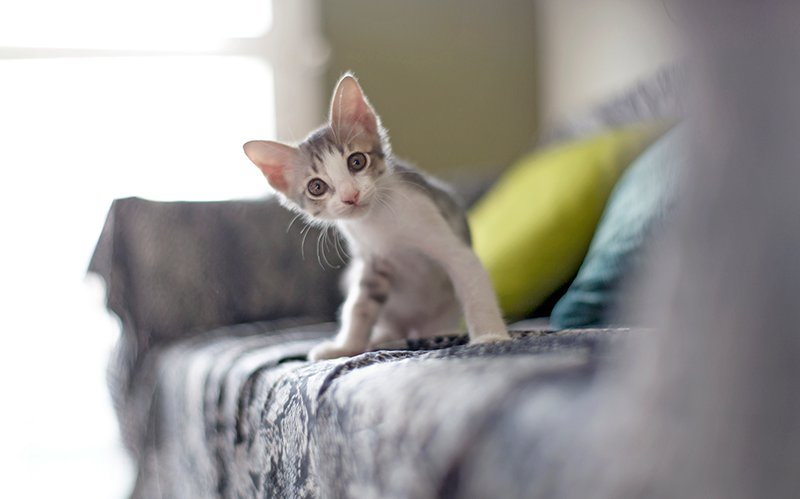

In [37]:
# Dynamically select a file from each class to validate dataset structure:
class_dir = os.path.join(combo_path, 'valid', 'badger')
if os.path.exists(class_dir):
    random_file = random.choice(os.listdir(class_dir))
    image_path = os.path.join(class_dir, random_file)
    img = Image.open(image_path)
    img.show()
else:
    print(f"No images found in {class_dir}")

In [38]:
combo_path = '/home/ec2-user/SageMaker/data/comboset'

In [39]:
print(combo_path)

/home/ec2-user/SageMaker/data/comboset


In [40]:
print(combined_classes)

['badger', 'cat', 'chimpanzee', 'cow', 'coyote', 'elephant', 'gorilla', 'orangutan', 'penguin', 'person', 'porcupine', 'possum', 'rhinoceros', 'sheep', 'starfish', 'whale', 'wombat', 'zebra']


##### Verify Train Loader Data Is Correct Before Training

In [41]:
verify_images(train_path)
verify_images(valid_path)
verify_images(test_path)

# **Classification Or Object Detection Model?**

### Classification Task (e.g., Image Classification)
If your CNN is being used for a classification problem (detecting whether an object is a person or non-person, or multi-class classification), the outputs will likely be logits (raw scores before softmax) from the final layer. You need to convert them to class predictions and compare them with the ground-truth labels.

In [42]:
def calculate_accuracy(outputs, labels):
    """
    Calculate accuracy for a classification CNN model.
    Args:
        outputs (torch.Tensor): Model outputs (logits) of shape [batch_size, num_classes].
        labels (torch.Tensor): Ground truth class labels of shape [batch_size].
    Returns:
        float: Accuracy as a fraction of correct predictions.
    """
    # Get the predicted class with highest probability
    preds = outputs.argmax(dim=1)  # Assuming CrossEntropyLoss
    correct = (preds == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy
    
    # _, preds = torch.max(outputs, dim=1)  # Convert logits to predicted class indices
    # correct = (preds == labels).float()   # Check which predictions are correct
    # return correct.mean()                 # Compute the accuracy

### Regression Task (e.g., Object Detection or Localization)
If your CNN is being used for regression-based tasks (e.g., predicting bounding box coordinates, keypoints, or other continuous outputs), accuracy isn’t meaningful. Instead, you use metrics like Mean Squared Error (MSE) or R² (coefficient of determination).

In [43]:
def calculate_regression_metrics(outputs, labels):
    """
    Calculate MSE and R² metrics for a regression CNN model.
    Args:
        outputs (torch.Tensor): Model outputs of shape [batch_size, output_dim].
        labels (torch.Tensor): Ground truth values of shape [batch_size, output_dim].
    Returns:
        dict: Dictionary with "MSE" and "R2" scores.
    """
    mse = torch.mean((outputs - labels) ** 2).item()  # Mean Squared Error
    total_variance = torch.mean((labels - labels.mean()) ** 2).item()
    explained_variance = total_variance - mse
    r2_score = explained_variance / total_variance if total_variance > 0 else 0.0
    return {"MSE": mse, "R2": r2_score}

# Comboset Transforms & Loaders <a id="transforms-loaders"></a>

Calculated Mean: tensor([0.4713, 0.4595, 0.4212])
Calculated Std: tensor([0.2065, 0.2032, 0.2050])
Batch 1: torch.Size([32, 3, 320, 320])
Data loaders calculated mean and std.


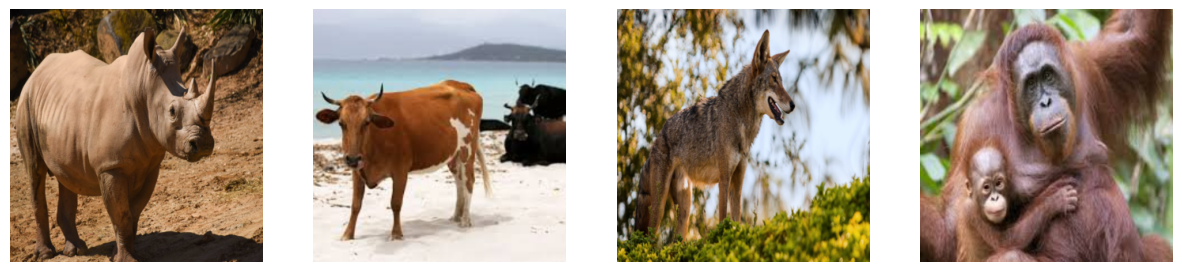

Number of Output Classes: 18


In [44]:
# Define transformations
# utilize dataloader
# ml.g4dn.2xlarge Instance

batch_size = 32  # Set the batch size as per your requirements
val_test_batch_size = 64  # Validation and test batch size
temp_batch_size = 16  # Batch size for mean/std calculation

# Step: Minimal transformation for mean and std calculation
resize_transformation = transforms.Compose([
    transforms.Resize(((320, 320))),  # Ensure consistent resizing
    transforms.ToTensor()           # Convert images to tensors
])

# Temporary DataLoader for calculating mean and std
temp_loader = DataLoader(
    ImageFolder(train_path, transform=resize_transformation),
    batch_size=16, shuffle=False
)

# Calculate mean and std of the training dataset
train_mean, train_std = calculate_mean_std(temp_loader)
print(f"Calculated Mean: {train_mean}")
print(f"Calculated Std: {train_std}")

# Data Augmentation for Training Dataset
# Update transformations for training and validation
train_transforms = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.2),
    # transforms.RandomRotation(20),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.3, hue=0.1),
    transforms.RandomResizedCrop(320, scale=(0.7, 1.0)),  # Random crop for zoom effect
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean.tolist(), std=train_std.tolist())
])
val_test_transformation = transforms.Compose([
    transforms.Resize((320, 320)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean.tolist(), std=train_std.tolist())
])

train_dataset = datasets.ImageFolder(root=os.path.join(combo_path, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(root=os.path.join(combo_path, 'valid'), transform=val_test_transformation)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_test_batch_size, shuffle=False)

# Load datasets from the unified comboset folder
train_loader = DataLoader(
    ImageFolder(os.path.join(combo_path, 'train'), transform=train_transforms),
    batch_size=32, shuffle=True
)

# Check the shape of the batches
for i, (data, _) in enumerate(train_loader):
    print(f"Batch {i+1}: {data.shape}")  # Output: (batch_size, channels, height, width)
    if i == 0:  # Check only the first batch
        break

validation_loader = DataLoader(
    ImageFolder(os.path.join(combo_path, 'valid'), transform=val_test_transformation),
    batch_size=64, shuffle=False
)

test_loader = DataLoader(
    ImageFolder(os.path.join(combo_path, 'test'), transform=val_test_transformation),
    batch_size=64, shuffle=False
)

print("Data loaders calculated mean and std.")

# Denormalization for visualization
mean = [0.4713, 0.4595, 0.4212]
std= [0.2065, 0.2032, 0.2050]

def denormalize(tensor):
    """Denormalize the tensor for visualization."""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse the normalization
    return tensor

train_dataset_aug = ImageFolder(os.path.join(in_path, 'train'), transform=train_transformation)

data_iter = iter(DataLoader(an_train, batch_size=4, shuffle=True))
images, labels = next(data_iter)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):  # Show 4 augmented images
    img = denormalize(images[i].clone())
    axes[i].imshow(img.permute(1, 2, 0).numpy())  # (C, H, W) -> (H, W, C)
    axes[i].axis('off')
# ran_index = random.randint(0, len(images) - 1)
# plt.imshow(images[0].permute(1, 2, 0).numpy())  # Show the first resized image
plt.show()

# Set the number of output classes dynamically
out_classes = len(combined_classes)
print(f"Number of Output Classes: {out_classes}")

### **Verify Class Counts**

In [45]:
# Check class distribution in training dataset
class_counts = Counter([sample[1] for sample in train_loader.dataset.samples])
print("Class Counts:", class_counts)

Class Counts: Counter({9: 632, 0: 38, 1: 38, 2: 38, 3: 37, 4: 37, 5: 37, 6: 37, 7: 37, 8: 37, 10: 37, 11: 37, 12: 37, 13: 37, 14: 37, 15: 37, 16: 37, 17: 37})


In [46]:
for images, labels in train_loader:
    print(f"Image: {images.shape}")  # (batch_size, channels, height, width)
    print(f"Label: {labels.shape}")  # (batch_size,)
    break  # one batch

Image: torch.Size([32, 3, 320, 320])
Label: torch.Size([32])


# CNN Model <a id="cnn-model"></a>

### Define Class Weights <a id="define-class-weights"></a>
Defining Class Weights prior to the CNN does not affect model initialization.

In [47]:
# Assuming train_loader is your DataLoader
class_labels = [label for _, label in train_loader.dataset]

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Automatically balance based on class frequencies
    classes=np.unique(class_labels),  # unique class labels
    y=class_labels  # All labels
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

print(f"Class Weights: {class_weights_tensor}")

Class Weights: tensor([1.8480, 1.8480, 1.8480, 1.8979, 1.8979, 1.8979, 1.8979, 1.8979, 1.8979,
        0.1111, 1.8979, 1.8979, 1.8979, 1.8979, 1.8979, 1.8979, 1.8979, 1.8979],
       device='cuda:0')


### Define CNN Model Architecture <a id="define-cnn-model"></a>

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the CNN
net = nn.Sequential(
    # First Convolutional Block
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    # Second Convolutional Block
    nn.Conv2d(64, out_channels=128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    # Third Convolutional Block
    nn.Conv2d(128, out_channels=256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    # Fourth Convolutional Block
    nn.Conv2d(256, out_channels=512, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)), # Reduce to 1x1 spatial dimensions
    # The flatten layer collapses all axes,
    # except the first one, into one axis.
    # Fully Connected Layers
    nn.Flatten(),
    nn.Linear(512, 256), # Input from reduced convolutional output
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(256, out_classes)).to(device)

# TRYING THIS - CUDA WOULDNT WORK SCRAP
# Apply `torch.compile` to optimize the model for better execution speed
# net = torch.compile(net)

print(next(net.parameters()).device) 

cuda:0


In [49]:
# Calculate total parameters
total_params = sum(p.numel() for p in net.parameters())
# Calculate trainable parameters
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

Total Parameters: 1688850
Trainable Parameters: 1688850


## Weights & Biases <a id="weights-biases"></a>

Reset weights after defining classweights.

In [50]:
def reset_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        m.reset_parameters()

net.apply(reset_weights)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): AdaptiveAvgPool2d(output_s

## Weight Initialization <a id="weight-initialization"></a>

Xavier Initialization & Kaiming Initialization

In [51]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)  # Xavier initialization
        if m.bias is not None:
            nn.init.zeros_(m.bias)  # Initialize bias to 0
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [52]:
net.apply(weights_init)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): AdaptiveAvgPool2d(output_s

## Hyperparameters <a id="hyperparameters"></a>

### Loss Function, Optimizer, and Evaluation Metric

Set hyperparameters:
- Device for training is GPU or CPU?
- Epochs to train the model.
- Learning rate of optimization algorithm.

In [73]:
# Num of epochs for training model
epochs = 200
batch_size = 32 # 32
learning_rate = 0.003
accumulation_steps = 2

### Mixed Precision Training - Autocast & GradScaler

In [54]:
from sklearn.metrics import f1_score
all_labels=[]
all_preds=[]
f1 = f1_score(all_labels, all_preds, average='macro')

### Loss Function - **Cross Entropy** with optional class weights or **Focal Loss**
__Cross Entropy__ is a loss function thast has common use in Classification. Cross Entropy measures the distance between predicted probability and actual label distribution. This in turn helps with adjusting the weights during model training.

__Focal Point__ is a loss function that is useful in Classification when you have class imbalance. Much like this notebook, it is the merging of two datasets into an imbalanced dataset with person having the same number of images as the 17 animal sets combined. 

In [55]:
# Define FocalLoss Function
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Add small epsilon for numerical stability
        ce_loss = F.cross_entropy(inputs, targets, reduction='none') + 1e-6
        p_t = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

In [56]:
criterion = FocalLoss(alpha=1, gamma=2)
# criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
# criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))

### **Optimizer & Learning Rate Scheduler**

__SGD (Stochastic Gradient Descent)__ - Basic optimization algorithm that updates model parameters using the gradient of the loss function. It uses a constant learning rate unless explicitly adjusted through a scheduler.

__Adam (Adaptive Moment Estimation)__ - Dynamic optimization algorithm that adjusts learning rates for each parameter individually using moving averages of gradients and their squared values.

__AdamW (Adaptive Moment Estimation with Weight Decay)__ - Dynamic optimization algorithm. AdamW is like Adam but with weight decay. It works in weight decay seperate from the training model in a bid to not allow overfitting, How? By reducing parameter size during training.

In [57]:
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, weight_decay=5e-3)
scaler = torch.cuda.amp.GradScaler()
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)

## Class Confirmation In Data <a id="class-confirmation"></a>

In [58]:
# Check the classes in the dataset
print(f"Classes in the dataset: {combined_classes}")
print(f"Number of classes: {len(combined_classes)}")
# out_classes = len(train_loader.dataset.classes)  # Automatically set to match dataset
out_classes

Classes in the dataset: ['badger', 'cat', 'chimpanzee', 'cow', 'coyote', 'elephant', 'gorilla', 'orangutan', 'penguin', 'person', 'porcupine', 'possum', 'rhinoceros', 'sheep', 'starfish', 'whale', 'wombat', 'zebra']
Number of classes: 18


18

Training - during an epoch there is forward propogation, loss calculation, backward propogation and weight update

torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()

## Profile Memory Usage <a id="profile-memory"></a>
Use PyTorch's profiler to identify which part of your code is consuming the most memory:

In [59]:
from torch.profiler import profile, record_function, ProfilerActivity
from torchvision.transforms import ToTensor

# Assuming `train_loader` is your DataLoader
data_iter = iter(train_loader)  # Get an iterator for the DataLoader
data, labels = next(data_iter)  # Retrieve a batch of data and labels

# Move the data and labels to the device
data = data.to(device)
labels = labels.to(device)

# Profile the model
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_training"):
        output = net(data)  # Forward pass through the model

# Print profiling results
print(prof.key_averages().table(sort_by="cuda_time_total"))

STAGE:2024-12-14 15:42:44 10617:10617 ActivityProfilerController.cpp:311] Completed Stage: Warm Up


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                         model_training         0.01%       1.716ms       100.00%       16.119s       16.119s       0.000us         0.00%     102.069ms     102.069ms             1  
                                           aten::conv2d         0.00%      35.000us        90.30%       14.557s        3.639s       0.000us         0.00%      54.093ms      13.523ms             4  
         

STAGE:2024-12-14 15:43:00 10617:10617 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2024-12-14 15:43:00 10617:10617 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


# Training CNN Model <a id="training-model"></a>

In [74]:
optimizer.zero_grad()  # init gradients out of loop
torch.cuda.empty_cache()  # Clear GPU Memory Before Training

# Initialize lists to store loss values
train_losses = []
val_losses = []
train_acc = []
valid_acc = []

for epoch in range(epochs):
    net.train()  # Activate training mode
    train_loss, train_acc = 0., 0.
    val_loss, valid_acc = 0., 0.

    # Training Loop
    for i, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)

        # Mixed precision forward pass
        with autocast():  # Enable mixed precision
            output = net(data)
            loss = criterion(output, label)

        # Check if loss has NaNs, Infs before backpropagation
        if not torch.isnan(loss).any() and not torch.isinf(loss).any():
            # Backward pass with scaled gradients
            scaler.scale(loss).backward()

            # Gradient clipping BEFORE optimizer step
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)

            # Gradient accumulation or optimizer step
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                scaler.step(optimizer)  # Apply optimizer step
                scaler.update()  # Update scaler for next iteration
                optimizer.zero_grad()  # Reset gradients
        else:
            print(f"Skipping step due to NaN/Inf in loss at iteration {i+1}")
        # Accumulate training accuracy and loss
        # train_acc += calculate_accuracy(output, label)
        # WEWOOOOEWOOOOOOOOEWOOOOOOOOWEWOOOOOOO
        train_acc += (output.argmax(dim=1) == label).sum().item() / len(label) # MAYYBE SWITCH BACK ^
        train_loss += loss.item()

    # Average training metrics for the epoch
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    # Initialize precision-recall trackers
    all_preds = []
    all_labels = []
    
    # Validation Loop
    net.eval()  # Activate evaluation mode
    val_loss, valid_acc = 0., 0.
    
    
    with torch.no_grad():
        for data, label in validation_loader:
            data, label = data.to(device), label.to(device)

            # with autocast():  # Mixed precision for validation
            output = net(data)
            loss = criterion(output, label)
            
            # Collect predictions and labels for precision-recall calculation
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())

            # Accumulate validation accuracy and loss
            valid_acc += calculate_accuracy(output, label)
            val_loss += loss.item()

    # Average validation metrics for the epoch
    val_loss /= len(validation_loader)
    valid_acc /= len(validation_loader)
    
    # Calculate precision and recall
    # Check Predictions Before Calculating Metrics
    if len(set(all_preds)) > 1:  # Ensure there are predictions for at least 2 classes
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=1)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=1)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=1)
    else:  # If no valid predictions, set precision and recall to 0.0
        precision, recall, f1 = 0.0, 0.0, 0.0
    
    # Log metrics for the epoch
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Adjust learning rate
    scheduler.step()
    # scheduler.step(val_loss)

    print("Epoch %d: train loss %.3f, train acc %.3f, val loss %.3f, val acc %.3f, precision %.3f, recall %.3f, F1-score %.3f" % (
    epoch+1, train_loss, train_acc, val_loss, valid_acc, precision, recall, f1))

    # Clear GPU memory CUDA needs the memory
    torch.cuda.empty_cache()

Epoch 1: train loss 0.262, train acc 0.838, val loss 1.906, val acc 0.712, precision 0.486, recall 0.466, F1-score 0.459
Epoch 2: train loss 0.285, train acc 0.837, val loss 1.965, val acc 0.674, precision 0.473, recall 0.419, F1-score 0.466
Epoch 3: train loss 0.299, train acc 0.832, val loss 1.917, val acc 0.667, precision 0.448, recall 0.457, F1-score 0.433
Epoch 4: train loss 0.286, train acc 0.845, val loss 1.885, val acc 0.698, precision 0.453, recall 0.449, F1-score 0.436
Epoch 5: train loss 0.305, train acc 0.823, val loss 2.019, val acc 0.670, precision 0.419, recall 0.447, F1-score 0.468
Epoch 6: train loss 0.303, train acc 0.822, val loss 1.995, val acc 0.697, precision 0.467, recall 0.451, F1-score 0.434
Epoch 7: train loss 0.313, train acc 0.819, val loss 1.836, val acc 0.694, precision 0.450, recall 0.447, F1-score 0.487
Epoch 8: train loss 0.292, train acc 0.825, val loss 1.867, val acc 0.708, precision 0.469, recall 0.480, F1-score 0.463
Epoch 9: train loss 0.256, train

##  **Test Accuracy** of CNN Training <a id="test-accuracy"></a>

In [72]:
test_acc = 0.
net.eval() # Activate evaluation mode
with torch.no_grad():

    with torch.no_grad():
        for data, label in test_loader:
            data = data.to(device)
            label = label.to(device)
            # Make forward pass with the trained model so far
            output = net(data)
            # Accumulate validation accuracy and loss
            test_acc += calculate_accuracy(output, label)

test_acc = test_acc/len(test_loader)

print("Test accuracy: %.3f" % test_acc)

Test accuracy: 0.688


# **Visualizations** <a id="visualizations"></a>

See what is happening with your training model

### **Summary - everything** <a id="summary"></a>

In [62]:
summary(net, input_size=(3, 320, 320))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]           1,792
       BatchNorm2d-2         [-1, 64, 320, 320]             128
              ReLU-3         [-1, 64, 320, 320]               0
         MaxPool2d-4         [-1, 64, 160, 160]               0
            Conv2d-5        [-1, 128, 160, 160]          73,856
       BatchNorm2d-6        [-1, 128, 160, 160]             256
              ReLU-7        [-1, 128, 160, 160]               0
         MaxPool2d-8          [-1, 128, 80, 80]               0
            Conv2d-9          [-1, 256, 80, 80]         295,168
      BatchNorm2d-10          [-1, 256, 80, 80]             512
             ReLU-11          [-1, 256, 80, 80]               0
        MaxPool2d-12          [-1, 256, 40, 40]               0
           Conv2d-13          [-1, 512, 40, 40]       1,180,160
      BatchNorm2d-14          [-1, 512,

### Model Performance Function <a id="model-performance"></a>

In [63]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    test_loss = 0.0

    with torch.no_grad():  # Disable gradient computation
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)  # Forward pass
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, preds = torch.max(outputs, 1)  # Get predicted classes
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds)
    test_accuracy = accuracy_score(all_labels, all_preds)

    return conf_matrix, class_report, test_accuracy, test_loss / len(dataloader)  # Function ends here

# Evaluate the model
conf_matrix, class_report, test_accuracy, avg_loss = evaluate_model(
    model=net,
    dataloader=test_loader,
    criterion=criterion,
    device=device
)

# Print results
print("Model performance on the test set:")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Average Test Loss: {avg_loss:.4f}")

Model performance on the test set:
Confusion Matrix:
[[  0   2   0   0   0   0   0   0   0   0   0   1   0   0   1   0   0   1]
 [  0   9   3   0   0   0   1   0   1   0   0   0   0   0   0   0   0   0]
 [  2   0   5   3   0   0   0   0   0   0   0   3   0   0   0   0   0   0]
 [  0   0   0   8   2   0   0   0   0   0   1   0   0   0   0   0   5   0]
 [  2   0   0   0   3   4   0   0   0   0   1   0   1   0   0   0   1   0]
 [  0   0   0   0   0   7   4   0   0   0   1   0   1   0   0   0   1   1]
 [  0   0   0   0   0   1   6   4   0   0   2   1   0   0   0   0   0   0]
 [  1   0   1   0   0   0   0   7   4   0   0   0   1   0   0   1   0   0]
 [  0   0   1   0   0   0   0   0   5   0   5   1   0   0   0   2   0   0]
 [  7   0   0   1   1   1   1   0   0 242   3   0   1   0   0   0   2   1]
 [  2   1   0   0   0   0   0   0   0   1   8   2   0   0   1   0   0   0]
 [  1   0   0   0   0   2   1   0   1   1   1   6   3   0   0   0   0   0]
 [  0   1   0   0   1   0   0   0   1   0   0  

### Training & Validation Loss Plots <a id="training-validation-loss"></a>

In [64]:
def plot_losses(train_losses, train_acc, valid_acc):

    train_acc = []
    valid_acc = []

    plt.plot(train_losses, label="Training Loss")
    plt.title("Loss values")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.plot(train_acc, "g", label="Train Accuracy")
    plt.plot(valid_acc, "red", label="Validation Accuracy")
    plt.title("Accuracy values")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

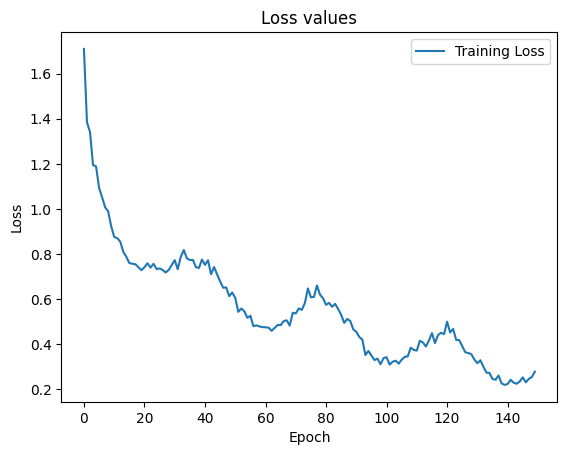

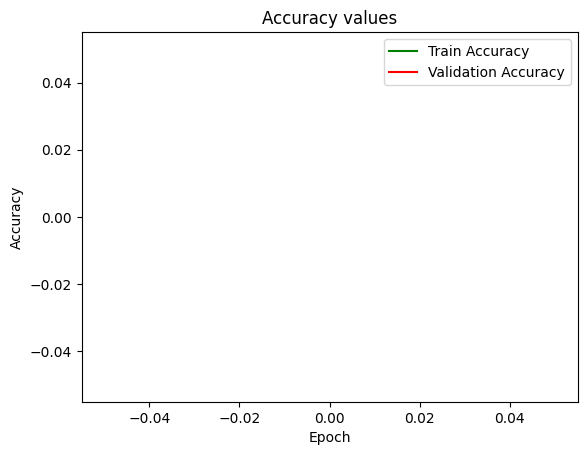

In [65]:
# train loss function and accuracy plot
plot_losses(train_losses, train_acc, valid_acc)

### Confusion Matrixes <a id="confusion-matrices"></a>

Confusion Matrix:
[[  2  10   2   0   0   0   0   0   2   0   0   2   0   0   2   0   0   0]
 [  2  18   8   0   2   0   6   2   0   0   0   2   0   0   2   0   0   4]
 [  8   0  18  16   0   2   2   0   0   0   0   4   0   0   0   0   0   4]
 [  2   2   0  28   8   0   0   0   0   0   6   4   0   4   0   0   4   0]
 [  2   0   0   0  16  10   0   0   0   2   8   0  10   0   2   0   0   0]
 [  4   0   4   0   2  20  10   0   0   0   4   2   4   0   0   0   2   2]
 [  0   2   0   2   0   0  26  14   0   0   2   2   0   0   0   0   2   0]
 [  0   0   2   2   0   0   0  26  16   0   0   2   2   0   0   2   0   0]
 [  2   4   2   0   0   0   2   0  24   0  16   2   2   0   0   2   0   2]
 [ 10   0   2   2   6   4   4   4   0 858  24   2   4   0   0   0   4   2]
 [  6   0   0   0   0   0   4   4   0   0  32   4   0   0   4   0   0   0]
 [  4   0   0   0   0   6   0   0   2   2   2  20  12   0   2   0   0   0]
 [  6   4   0   0   4   2   0   0   0   0   2   0  20  12   0   0   2   0]
 [  6  

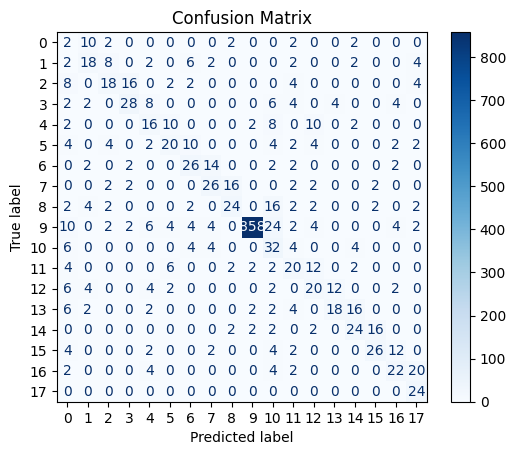

In [66]:
# Validation loop to collect predictions & labels
net.eval()  # Set model to evaluation mode
with torch.no_grad():
    for data, label in validation_loader:
        data, label = data.to(device), label.to(device)

        # Forward pass
        output = net(data)

        # Get predictions
        preds = output.argmax(1)

        # Store predictions and labels
        all_preds.extend(preds.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.extend(label.cpu().numpy())  # Move to CPU and convert to numpy

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=range(out_classes))

# Print confusion matrix txt file
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(out_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Confusion Matrix (Raw Counts):
[[  2  10   2   0   0   0   0   0   2   0   0   2   0   0   2   0   0   0]
 [  2  18   8   0   2   0   6   2   0   0   0   2   0   0   2   0   0   4]
 [  8   0  18  16   0   2   2   0   0   0   0   4   0   0   0   0   0   4]
 [  2   2   0  28   8   0   0   0   0   0   6   4   0   4   0   0   4   0]
 [  2   0   0   0  16  10   0   0   0   2   8   0  10   0   2   0   0   0]
 [  4   0   4   0   2  20  10   0   0   0   4   2   4   0   0   0   2   2]
 [  0   2   0   2   0   0  26  14   0   0   2   2   0   0   0   0   2   0]
 [  0   0   2   2   0   0   0  26  16   0   0   2   2   0   0   2   0   0]
 [  2   4   2   0   0   0   2   0  24   0  16   2   2   0   0   2   0   2]
 [ 10   0   2   2   6   4   4   4   0 858  24   2   4   0   0   0   4   2]
 [  6   0   0   0   0   0   4   4   0   0  32   4   0   0   4   0   0   0]
 [  4   0   0   0   0   6   0   0   2   2   2  20  12   0   2   0   0   0]
 [  6   4   0   0   4   2   0   0   0   0   2   0  20  12   0   0   2

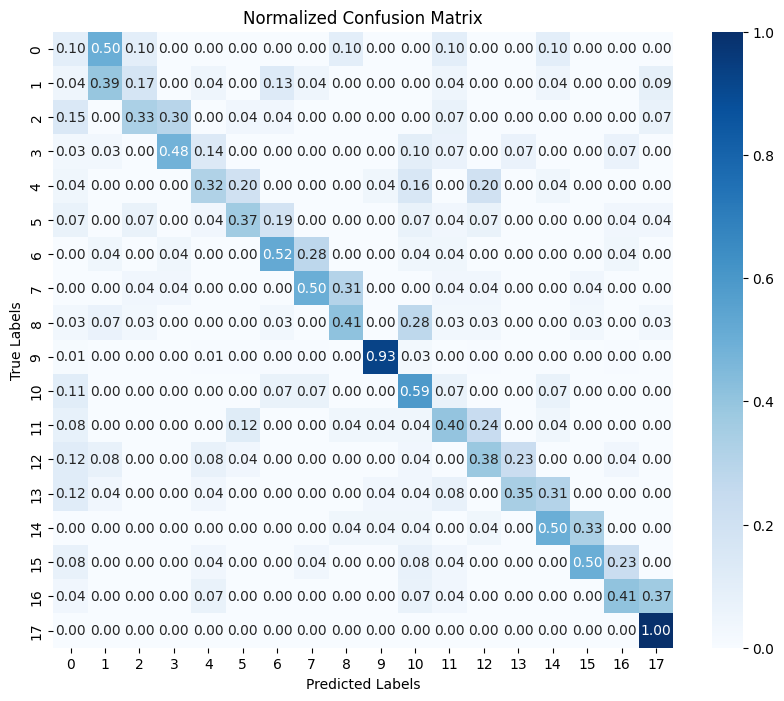

In [67]:
# Heatmap-style confusion matrix with correct predictions on diagonal and misclassifications in the off-diagonal entries.
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=range(out_classes))

# Check for empty rows
print("Confusion Matrix (Raw Counts):")
print(cm)

# Normalize the confusion matrix
cm_sum = cm.sum(axis=1)[:, np.newaxis]  # Sum of each row
cm_normalized = np.divide(cm.astype('float'), cm_sum, where=cm_sum != 0)  # Avoid division by zero
cm_normalized = np.nan_to_num(cm_normalized)  # Replace NaN with 0

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust size as needed
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=range(out_classes), yticklabels=range(out_classes))

# Add titles and labels
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Feature Maps <a id="feature-maps"></a>

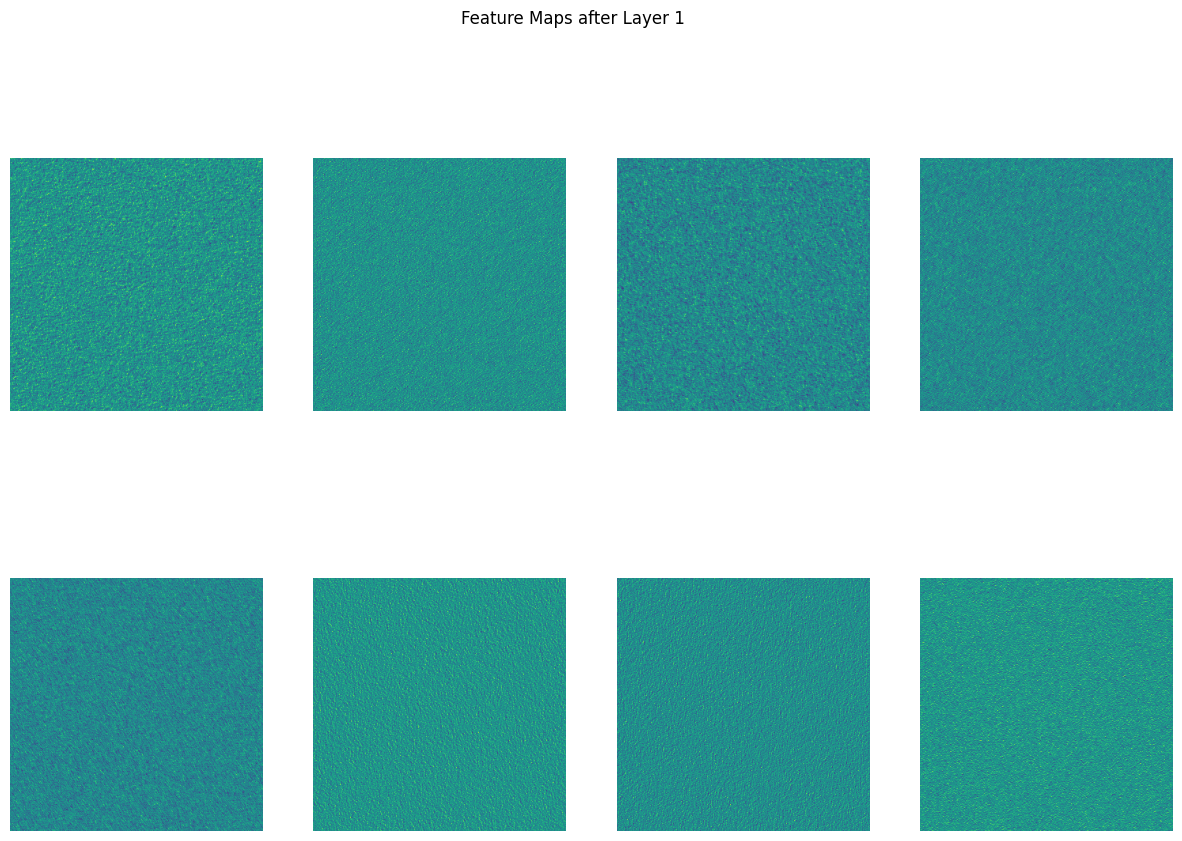

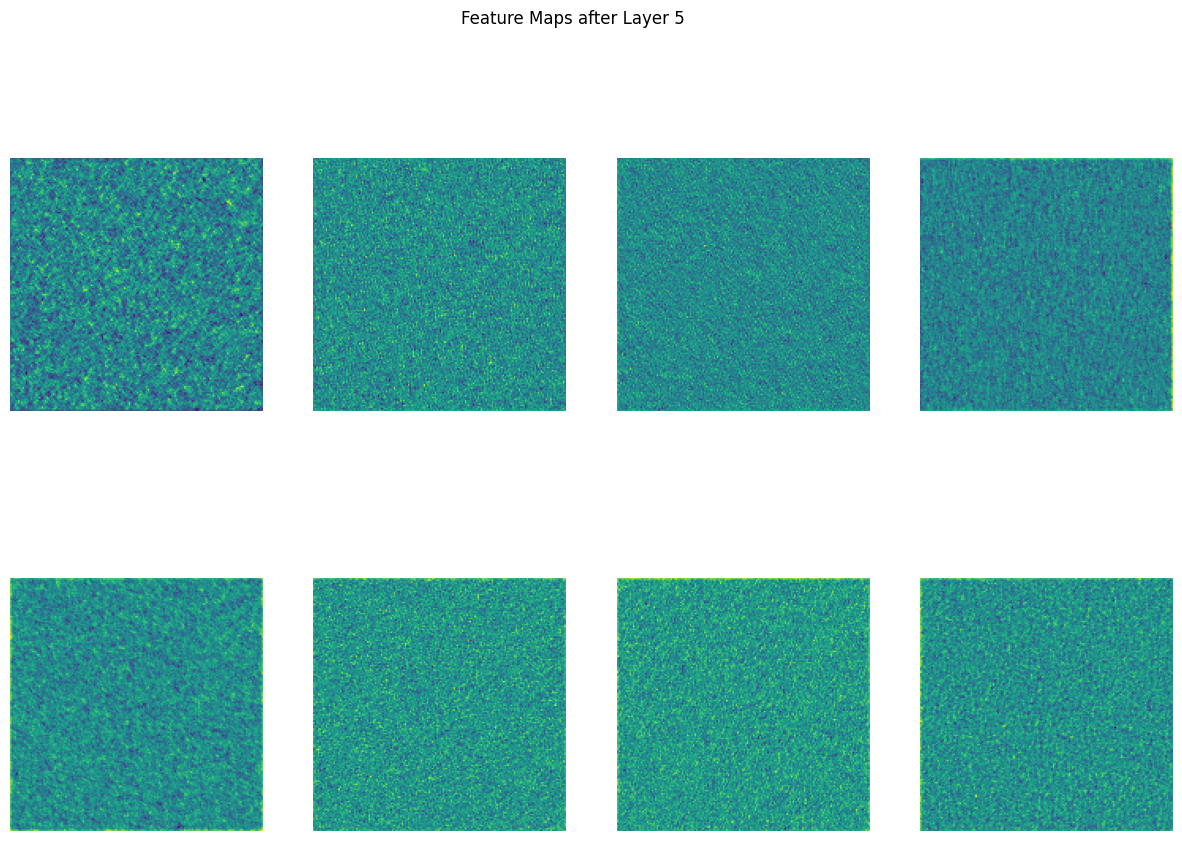

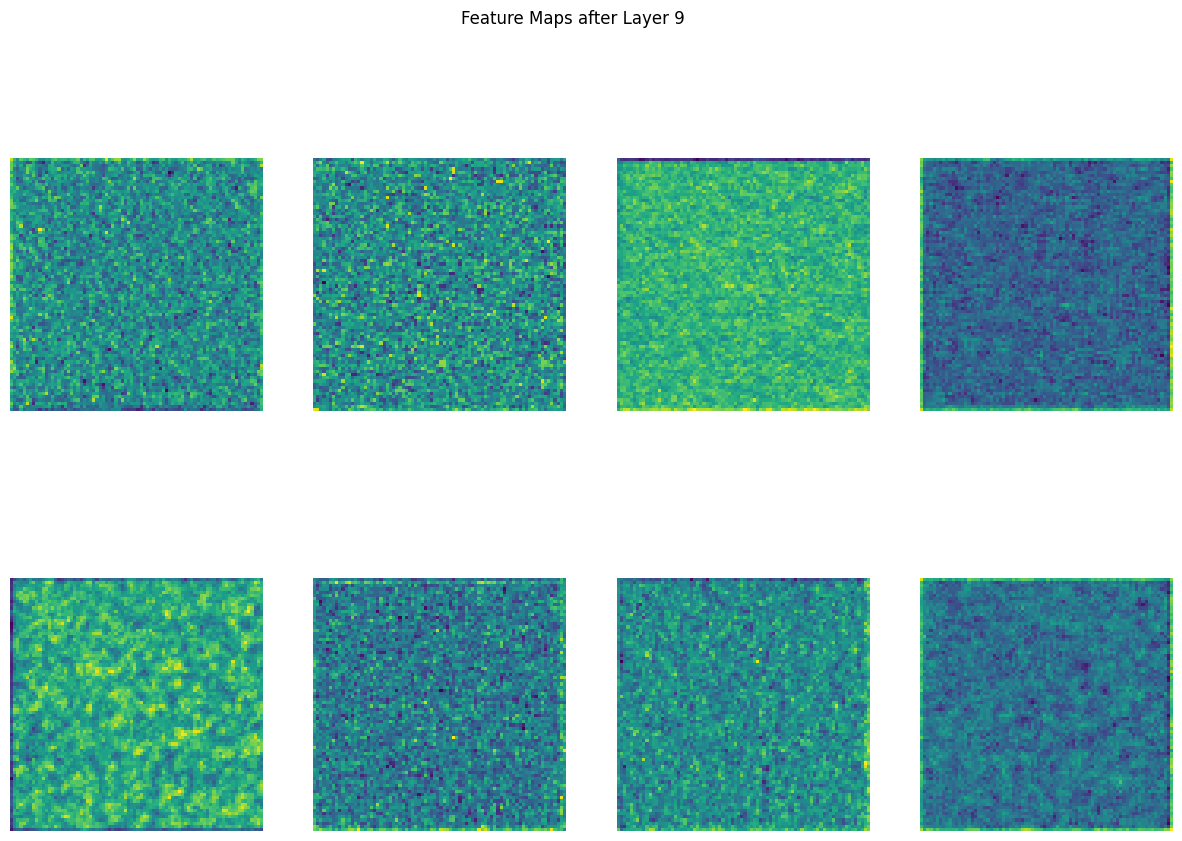

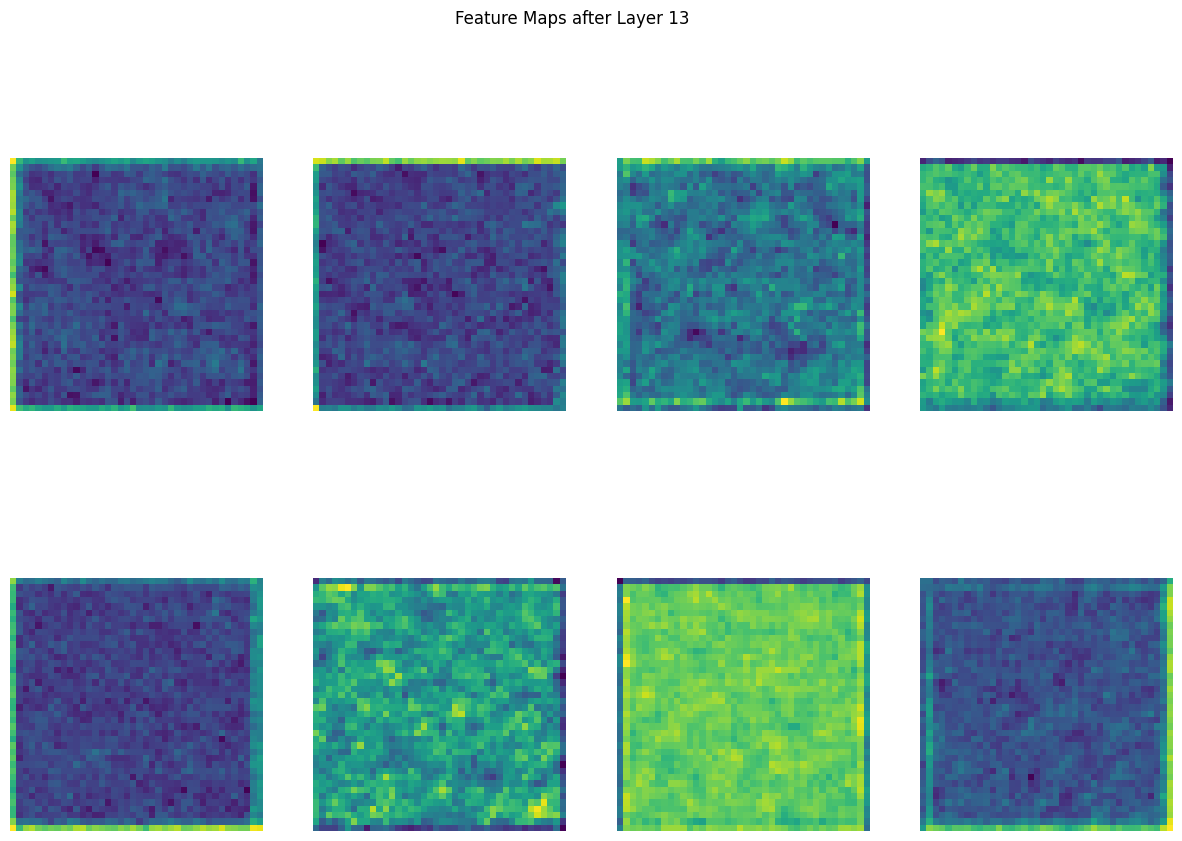

In [68]:
# Forward pass to extract feature maps
def visualize_feature_maps(model, input_image):
    model.eval()
    layers = list(model.children())[:-1]  # Exclude the final fully connected layer
    for idx, layer in enumerate(layers):
        input_image = layer(input_image)
        if isinstance(layer, nn.Conv2d):  # Visualize only Conv layers
            plt.figure(figsize=(15, 10))
            for i in range(min(8, input_image.size(1))):  # Show up to 8 feature maps
                plt.subplot(2, 4, i+1)
                plt.imshow(input_image[0, i].detach().cpu().numpy(), cmap="viridis")
                plt.axis("off")
            plt.suptitle(f"Feature Maps after Layer {idx + 1}")
            plt.show()

# Dummy input
dummy_input = torch.randn(1, 3, 320, 320).to(device)
visualize_feature_maps(net, dummy_input)

### Kernel/Visualizations <a id="kernel-visualizations"></a>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

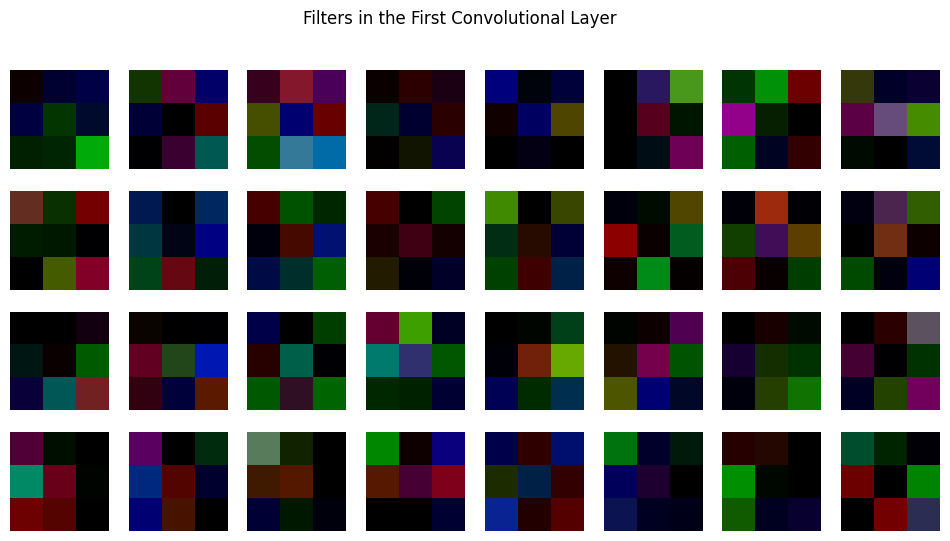

In [69]:
# Extract weights from the first convolutional layer
filters = net[0].weight.data.cpu()  # The first Conv2D layer is at index 0 in nn.Sequential

# Plot filters
fig, axes = plt.subplots(4, 8, figsize=(12, 6))  # Adjust rows/columns as needed
for i, ax in enumerate(axes.flat):
    if i < filters.size(0):  # Ensure not to exceed the number of filters
        ax.imshow(filters[i].permute(1, 2, 0).numpy(), cmap='viridis')  # Convert from (C, H, W) to (H, W, C)
        ax.axis("off")
plt.suptitle("Filters in the First Convolutional Layer")
plt.show()


### Gradient Visualization <a id="gradient-visualizations"></a>

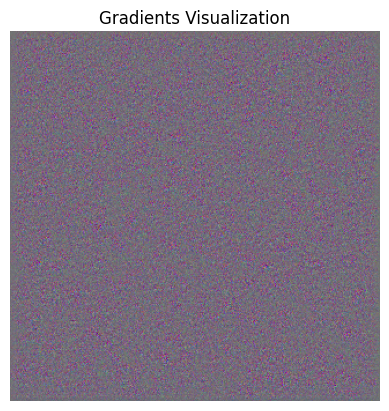

In [70]:
def visualize_gradients(model, input_image, target_label):
    input_image.requires_grad = True
    model.eval()
    output = model(input_image)
    loss = nn.CrossEntropyLoss()(output, target_label)
    loss.backward()
    gradients = input_image.grad.data.cpu().numpy()[0]
    
    # Normalize gradients for visualization
    gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min())
    
    # Visualize gradients
    plt.imshow(gradients.transpose(1, 2, 0), cmap="viridis")  # Adjust for RGB channels
    plt.title("Gradients Visualization")
    plt.axis("off")
    plt.show()

# Dummy input
dummy_input = torch.randn(1, 3, 320, 320).to(device)
dummy_target = torch.tensor([0]).to(device)  # Replace with
visualize_gradients(net, dummy_input, dummy_target)

### CAM/Grad-CAM <a id="cam-grad-cam"></a>

In [71]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision.transforms.functional import normalize

# Specify the target layers (last convolutional layer of ResNet-18)
target_layers = [net[-7]]  # Assuming AdaptiveAvgPool2d is at -3, and this Conv2d is at -7

# Create an input tensor (example input size: 640x640)
input_tensor = torch.randn(1, 3, 320, 320).to(device)  # Replace with your actual input image tensor

# Normalize the input tensor using the mean and std used during training
mean = [0.4713, 0.4595, 0.4212]
std = [0.2065, 0.2032, 0.2050]
input_tensor = normalize(input_tensor[0], mean=mean, std=std).unsqueeze(0)  # Normalize and add batch dimension

# Initialize Grad-CAM
cam = GradCAM(model=net, target_layers=target_layers)

# Generate Grad-CAM
targets = [ClassifierOutputTarget(0)]  # Replace 0 with the class index you want to visualize
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# Visualize Grad-CAM
grayscale_cam = grayscale_cam[0, :]  # Extract the first (and only) image
input_image = input_tensor[0].cpu().permute(1, 2, 0).numpy()  # Convert to HWC format for visualization
input_image = (input_image - input_image.min()) / (input_image.max() - input_image.min())  # Scale to [0, 1]
visual_cam = show_cam_on_image(input_image, grayscale_cam, use_rgb=True)

# Plot the visualization
plt.imshow(visual_cam)
plt.title("Grad-CAM Visualization")
plt.axis("off")
plt.show()

ModuleNotFoundError: No module named 'pytorch_grad_cam'

### Training/Validation Curves <a id="training-validation-curves"></a>

In [ ]:
# Find the minimum length among all lists
min_epochs = min(len(train_losses), len(val_losses), len(train_acc), len(val_acc))

# Plot Loss and Accuracy
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, min_epochs + 1), train_losses[:min_epochs], label="Train Loss")
plt.plot(range(1, min_epochs + 1), val_losses[:min_epochs], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, min_epochs + 1), train_accs[:min_epochs], label="Train Accuracy")
plt.plot(range(1, min_epochs + 1), val_accs[:min_epochs], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

### Explainability Tools<a id="explainability-tools"></a>

In [ ]:
import shap

explainer = shap.DeepExplainer(net, torch.randn(1, 3, 320, 320).to(device))
shap_values = explainer.shap_values(torch.randn(1, 3, 320, 320).to(device))

shap.image_plot(shap_values, np.ones((1, 320, 320), 3))  # Replace with actual image

In [ ]:
# Generate random data and make a scatterplot of it

# Generate random data
x = np.random.rand(100)
y = np.random.rand(100)

# Plot the data
plt.scatter(x, y)
plt.show()

# **Acknowledgements** <a id="acknow"></a>


<p>I would like to express my gratitude to <strong>Dr. Michael Soltys</strong> and <strong>Dr. William Barber</strong> for sparking my interest in Machine Learning and Artificial Intelligence. Over the past two years at <em>California State University Channel Islands (CSUCI)</em>, it has been a pleasure taking multiple courses with both professors, each bringing their own perspectives and experiences. They both were able to articulate complex information in a digestible way effortlessly.</p>

<h3>Dr. William Barber</h3>
<p>
Dr. Barber, with his background in <strong>Physics</strong> and a distinguished career in <strong>Medical Imaging and Research</strong>, provided a scientific and mathematical foundation that enhanced my understanding of computational models, data analysis, and data extraction. His extensive industry experience includes serving as <strong>Director of Medical Imaging at Rapiscan Systems</strong>. His engaging teaching style and passion for image processing techniques and pattern recognition concepts inspired me to explore this field further.
</p>

<h3>Dr. Michael Soltys</h3>
<p>
Dr. Soltys, with his comprehensive background in <strong>Algorithms, Machine Learning, and Cloud Computing</strong>, fostered my interest in pursuing a Computer Vision Capstone Project. As an accomplished author of two books and more than 60 published research papers, Dr. Soltys brings a wealth of in-depth knowledge and real-world applications to his teaching. His courses and recommendations proved to be instrumental during the development of my <strong>Convolutional Neural Network (CNN)</strong> Capstone Project.
</p>

<h3>Bayne H. Ryan</h3>
<p>
Bayne, my dear nephew. You arrived the first week of December, right in the middle of preparations for my Capstone Showcase. I truly admire your impeccable sense of urgency to stop being a submarine and surface just in time to appreciate my Convolutional Neural Network (CNN) Capstone project. Your surprise guest appearance was undoubtedly the highlight of my year. I cannot wait to forcibly teach you calculus when you reach the prestigious age of juice boxes and nap time (also known as four years old).
</p>

## **Literature Cited** <a id="litcit"></a>

> Tan, M., & Le, Q. V. (2019). EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. arXiv preprint arXiv:1901.08688.

> Brownlee, J. How to Develop Convolutional Neural Network Models for Time Series Forecasting. Machine Learning Mastery. Available at: https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/.

> Dougherty, G. Pattern Recognition and Classification: An Introduction. Springer, 2012.

> Eliot, D. Deep Learning with PyTorch Step-by-Step: A Beginner's Guide, Volume I: Fundamentals. Self-published, 2020.

> Jocher, G., Chaurasia, A., & Qiu, J. (2023). Ultralytics YOLOv8. Available at: https://github.com/ultralytics/ultralytics.

# **Environment**

- **AWS SageMaker Jupyter Notebook**
  - **Notebook Instance Type:** ml.g4dn.2xlarge
  - **Processor:** NVIDIA T4 Tensor Core GPU with 16 GB GDDR6 VRAM
  - **Memory:** 32 GB System RAM
  - **Storage:** 5 GB EBS Volume
  - **Operating System:** Amazon Linux 2 with Jupyter Lab 3 (notebook-al2-v2)
  - **Lifecycle Configuration:** None
  - **Elastic Inference:** Not Enabled
  - **Minimum IMDS Version:** 2


# **Recommended Resources** <a id="recres"></a>

<p>Courses for Computer Science Students at <em>California State University Channel Islands (CSUCI)</em> Interested in Machine Learning & AI</p>

<h3><u>Channel Island Specific Courses:</u></h3>
<ul>
  <li><strong>COMP 345</strong> - Digital Image Processing (Fall Course)</li>
  <li><strong>COMP 354</strong> - Analysis of Algorithms</li>
  <li><strong>COMP 445</strong> - Image Analysis and Pattern Recognition (Spring Course)</li>
  <li><strong>COMP 454</strong> - Automata, Languages & Computation</li>
  <li><strong>COMP 469</strong> - Intro to Artificial Intelligence / Machine Learning (Fall Course)</li>
  <li><strong>COMP 491</strong> - Capstone Prep (Specifically with Dr. Soltys)</li>
  <li><strong>COMP 499</strong> - Capstone (Specifically with Dr. Soltys)</li>
</ul>

<p><em>Correlating Instructor to Specific Coursess:</em></p>
<ul>
  <li>COMP 345 & 445 are taught by Dr. Barber</li>
  <li>COMP 354, COMP 454, & COMP 469 are taught by Dr. Soltys</li>
</ul>

<h3><u>AWS Courses</u> (if offered):</h3>
<ul>
  <li>AWS MLU Machine Learning through Application (<strong>One Half of COMP 469</strong> with <strong>Soltys</strong> and it gives you a <strong>certificate</strong>)</li>
  <li>AWS MLU Application of Deep Learning to Text and Image Data (<strong>One Half of COMP 469</strong> with <strong>Soltys</strong> and it gives you a <strong>certificate</strong>)</li>
  <li>AWS DeepRacer Student</li>
</ul>

<h3><u>LinkedIn Learning Courses</u> (if offered): If you are a higher education student check if your university gives you access to LinkedInLearning.</h3>
<ul>
  <li>
    <a href="https://www.linkedin.com/learning/deep-learning-and-generative-ai-data-prep-analysis-and-visualization-with-python/leverage-generative-ai-for-analytics-and-insights?u=37164436" target="_blank">
      Deep Learning and Generative AI: Data Prep, Analysis, and Visualization with Python Leverage Generative AI for Analytics and Insights by Gwendolyn Stripling
    </a>
  </li>
  <li>
    <a href="https://www.linkedin.com/learning/deep-learning-image-recognition-24393297/learning-image-recognition?u=37164436" target="_blank">
      Deep Learning: Image Recognition Learning image recognition by Isil Berkun
    </a>
  </li>
  <li>
    <a href="https://www.linkedin.com/learning/advanced-ai-transformers-for-computer-vision/transformers-for-computer-vision?u=37164436" target="_blank">
      Advanced AI: Transformers for Computer Vision by Jonathan Fernandes
    </a>
  </li>
  <li>
    <a href="https://www.linkedin.com/learning/building-computer-vision-applications-with-python/building-computer-vision-applications-with-python?u=37164436" target="_blank">
      Building Computer Vision Applications with Python by Eduardo Corpeño
    </a>
  </li>
  <li>
    <a href="https://www.linkedin.com/learning/applied-machine-learning-algorithms-23750732/applied-machine-learning-algorithms?u=37164436" target="_blank">
      Applied Machine Learning: Algorithms by Matt Harrison
    </a>
  </li>
  <li>
    <a href="https://www.linkedin.com/learning/building-deep-learning-applications-with-keras/reshaping-the-world-with-deep-learning?u=37164436" target="_blank">
      Building Deep Learning Applications with Keras by Isil Berkun
    </a>
  </li>
</ul>

<h3><u>Helpful Resources:</u></h3>
<p>Resources that I found useful while working on a Computer Vision project and learning about Machine Learning & AI.</p>

<ul>
  <li>
    <a href="https://greenteapress.com/thinkpython2/thinkpython2.pdf" target="_blank">
      Think Python How to Think Like a Computer Scientist 2nd Edition, Version 2.4.0 by Allen Downey
    </a>
  </li>
    <li>
    <a href="https://github.com/dvgodoy/PyTorchStepByStep/blob/master/README.md" target="_blank">
      Deep Learning with PyTorch Step-by-Step: A Beginner's Guide: Volume I: Fundamentals by Daniel Voigt Godoy
    </a>
  </li>

  <li>
    <a href="https://link.springer.com/book/10.1007/978-1-4614-5323-9" target="_blank">
      Pattern Recognition and Classification An Introduction (Springer, 2012) by Geoff Dougherty
    </a>
  </li>

  <li>
    <a href="https://www.amazon.com/author/msoltys" target="_blank">
      An Introduction to the Analysis of Algorithms (3rd Ed, 2018) by Michael Soltys
    </a>
  </li>

  <li>
    <a href="https://docs.ultralytics.com/models/yolov8/" target="_blank">
      Ultralytics YOLOv8 Documentation
    </a>
  </li>

  <li>
    <a href="https://shisrrj.com/paper/SHISRRJ247267.pdf" target="_blank">
      Object Detection and Localization with YOLOv3 by B. Rupadevi and J. Pallavi
    </a>
  </li>

  <li>
    <a href="https://www.amazon.com/Digital-Image-Processing-Medical-Applications/dp/0521860857" target="_blank">
      Digital Image Processing for Medical Applications by Geoff Dougherty
    </a>
  </li>
</ul>

# **Permission**

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
</head>
<body>

<p>Students, educators, and anyone else keen on learning about Convolutional Neural Networks (CNNs), Computer Vision, Supervised Learning Algorithms, Machine Learning, Deep Learning, AI, or related fields are welcome to use this notebook in any capacity as a learning resource.</p>

<p>This notebook is part of my Fall 2024 Capstone Project for my Bachelor’s degree in Computer Science at California State University Channel Islands. I structured the content to be approachable and digestible, reflecting my own learning journey in AI and Machine Learning.</p>

<p>I hope this notebook can be of use to those exploring similar topics. This specific Jupyter Notebook focuses on Image Classification and demonstrates combining two datasets to create a class imbalance for training purposes. A separate notebook dedicated to Object Detection will be available soon (if not already).</p>

<h3>Important Note on Datasets:</h3>
<p>The datasets used in this project are not my property. Credit is given to the original dataset creators, and their links are provided within the notebook in the dataset section at the beginning.</p>

<p>I understand that grasping the fundamentals of CNNs and related AI concepts can be overwhelming at first. My goal is to make these topics more accessible through these notebooks.</p>

<h3>Permissions:</h3>
<p>You are free to download, use, edit, and reference the notebooks, Python code, and Markdown content. I aim for accuracy in the explanations provided, though I acknowledge that scientific understanding is always evolving. I welcome constructive feedback and corrections.</p>

<p>This project is intended as a learning resource.</p>

<p><strong>&mdash; Ian Ryan</strong></p>

</body>
</html>